nitime.timeseries.TimeSeries

(30, 182)

array([], shape=(0, 2), dtype=int64)

array([], shape=(0, 2), dtype=int64)

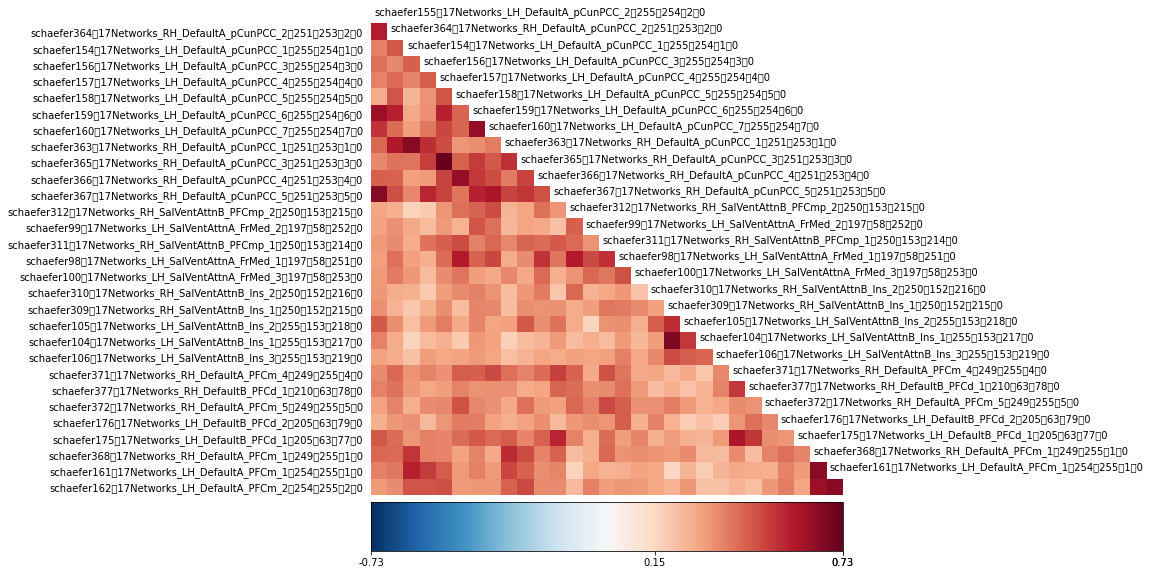

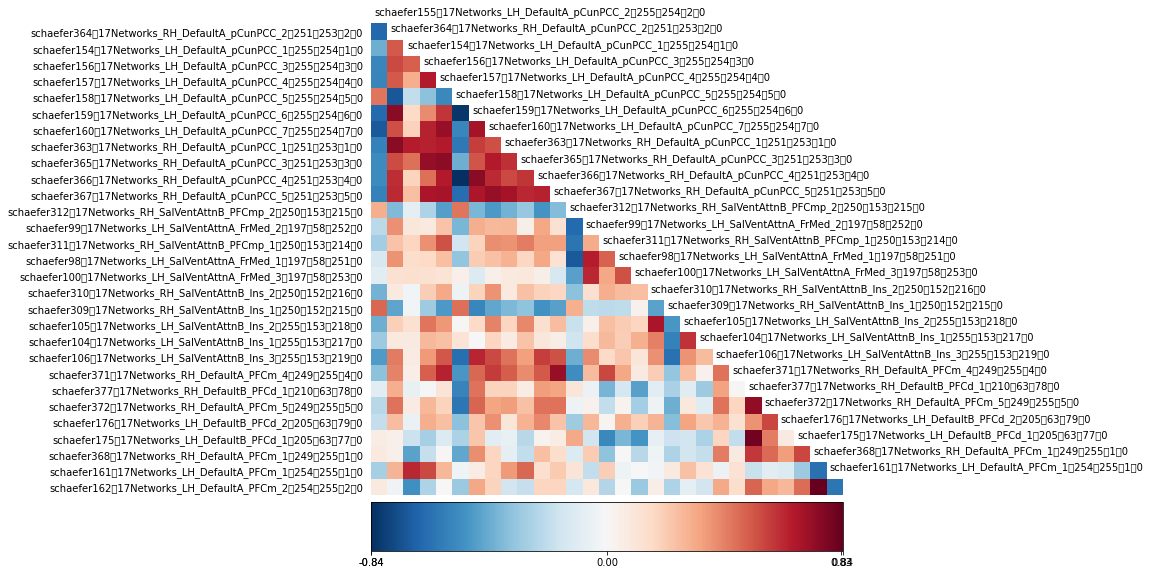

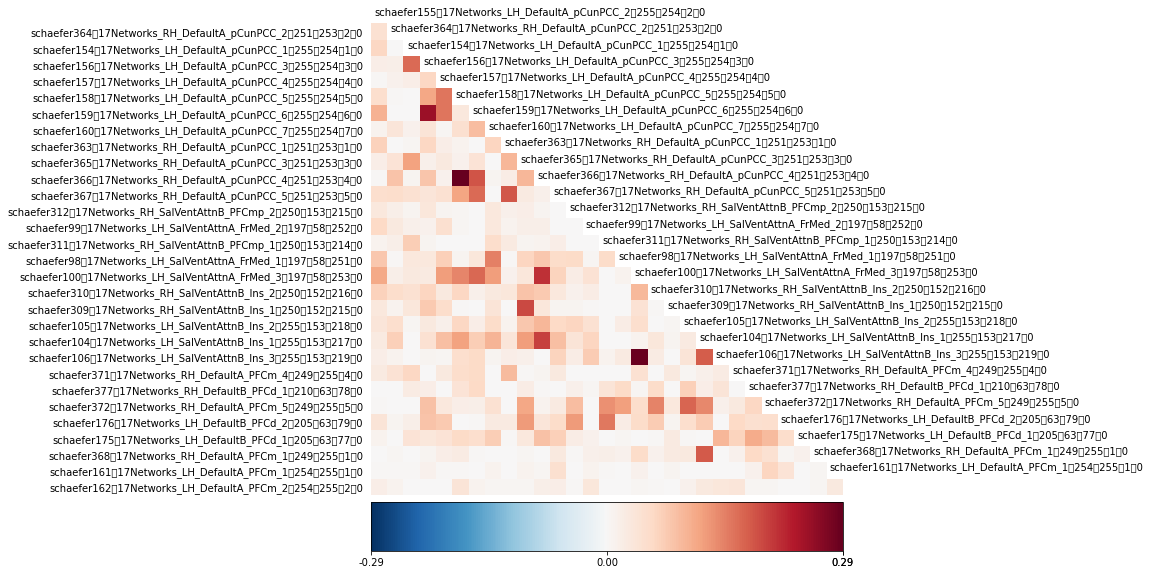

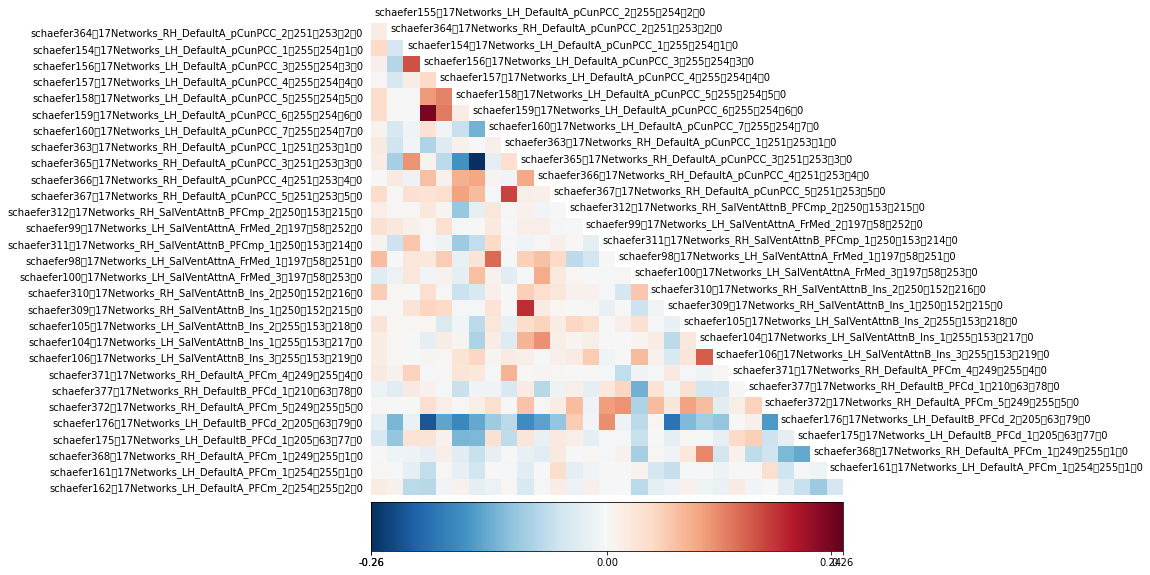

'\n/usr/local/lib/python3.7/site-packages/nitime/viz.py:284: RuntimeWarning: All-NaN slice encountered\n  max_val = np.nanmax(m)\n/usr/local/lib/python3.7/site-packages/nitime/viz.py:285: RuntimeWarning: All-NaN slice encountered\n  min_val = np.nanmin(m)\n/usr/local/lib/python3.7/site-packages/matplotlib/colorbar.py:768: RuntimeWarning: invalid value encountered in less_equal\n  b = b[(b <= intv[1] + eps) & (b >= intv[0] - eps)]\n/usr/local/lib/python3.7/site-packages/matplotlib/colorbar.py:768: RuntimeWarning: invalid value encountered in greater_equal\n  b = b[(b <= intv[1] + eps) & (b >= intv[0] - eps)]\n'

In [5]:
"""

.. gc-fmri

================================
Granger 'causality' of fMRI data
================================

Granger 'causality' analysis provides an asymmetric measure of the coupling
between two time-series. When discussing this analysis method, we will put the
word 'causality' in single quotes, as we believe that use of this word outside
of quotes should be reserved for particular circumstances, often not fulfilled
in the analysis of simultaneously recorder neuroscientific time-series (see
[Pearl2009]_ for an extensive discussion of this distinction).

The central idea behind this analysis is that time-series can be described in
terms of a time-delayed auto-regressive model of the form:

.. math::

   x_t = \sum_{i=1}^{n}a_i x_{t-i} + \epsilon_t

Here, the past behaviour of a single time-series is used in order to predict
the current value of the time-series. In Granger 'causality' analysis, we test
whether the addition of a prediction of the time-series from another
time-series through a multivariate auto-regressive model may improve our
prediction of the present behavior of the time-series (reducing the value of
the error term $\epsilon_t$):

.. math::

   x_t = \sum_{i=1}^{n}(a_i x_{t-i} + b_i y_{t-i}) + \epsilon_t


In our implementation of the algorithms used for this analysis, we follow
closely the description put forth by Ding et al. ([Ding2006]_). Also, see
:ref:`mar` and :ref:`ar` for examples even more closely modeled on the
examples mentioned in their paper.

Here, we will demonstrate the use of Granger 'causality' analysis with fMRI
data. The data is provided as part of the distribution and is taken from a
'resting state' scan. The data was motion corrected and averaged from several
ROIs.

We start by importing the needed modules:

"""

import os

import numpy as np
import matplotlib.pyplot as plt

import nitime
import nitime.analysis as nta
import nitime.timeseries as ts
import nitime.utils as tsu
from nitime.viz import drawmatrix_channels

from IPython.core.display import display, HTML

"""

We then define a few parameters of the data: the TR and the bounds on the
frequency band of interest.

"""

TR = 2.00
f_ub = 0.15
f_lb = 0.02

"""

We read in the resting state fMRI data into a recarray from a csv file:

"""

data_rec = np.genfromtxt("./timeseries_CSVs/ROI_Subject014_Session001.csv", dtype=float, delimiter=',', names=True)

roi_names = np.array(data_rec.dtype.names)
nseq = len(roi_names)
n_samples = data_rec.shape[0]
data = np.zeros((nseq, n_samples))

for n_idx, roi in enumerate(roi_names):
    data[n_idx] = data_rec[roi]

"""

We normalize the data in each of the ROIs to be in units of % change and
initialize the TimeSeries object:

"""

pdata = tsu.percent_change(data)
time_series = ts.TimeSeries(pdata, sampling_interval=TR)

"""

We initialize the GrangerAnalyzer object, while specifying the order of the
autoregressive model to be 1 (predict the current behavior of the time-series
based on one time-point back).

"""
display(type(time_series))
display(time_series.shape)
display(np.argwhere(np.isnan(time_series)))
display(np.argwhere(np.isinf(time_series)))
G = nta.GrangerAnalyzer(time_series, order=1)

"""

For comparison, we also initialize a CoherenceAnalyzer and a
CorrelationAnalyzer, with the same TimeSeries object:

"""

C1 = nta.CoherenceAnalyzer(time_series)
C2 = nta.CorrelationAnalyzer(time_series)

"""

We are only interested in the physiologically relevant frequency band
(approximately 0.02 to 0.15 Hz).

The spectral resolution is different in these two different analyzers. In the
CoherenceAnalyzer, the spectral resolution depends on the size of the window
used for calculating the spectral density and cross-spectrum, whereas in the
GrangerAnalyzer it is derived, as determined by the user, from the MAR model
used.

For this reason, the indices used to access the relevant part of the spectrum
will be different in the different analyzers.

"""

freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0]
freq_idx_C = np.where((C1.frequencies > f_lb) * (C1.frequencies < f_ub))[0]

#display(freq_idx_G)

"""

We plot the 'causality' from x to y ($F_{x \rightarrow y}$) and from y to x
($F_{y \rightarrow x}$ for the first two ROIs and compare to the coherence
between these two time-series:

"""

coh = np.mean(C1.coherence[:, :, freq_idx_C], -1)  # Averaging on the last dimension



g1 = np.mean(G.causality_xy[:, :, freq_idx_G], -1)
for i in range(len(g1)):
    for j in range(len(g1[i])):
        if np.isnan(g1[i][j]):
            if i == j:
                g1[i][j] = 1.0
            else:
                g1[i][j] = g1[j][i]


#print(g1)

#print(len(G._granger_causality['gc_xy'].keys()), "keys")

fig01 = drawmatrix_channels(coh, roi_names, size=[10., 10.], color_anchor=0)
fig02 = drawmatrix_channels(C2.corrcoef, roi_names, size=[10., 10.], color_anchor=0)
fig03 = drawmatrix_channels(g1, roi_names, size=[10., 10.], color_anchor=0)
"""
Differences in the HRF between different ROIs are a potential source of
misattribution of the direction and magnitude of dependence between time-series
in fMRI data (for a particularly extreme example of that see
[David2008]_). Therefore, as suggested by Roebroeck et al. [Roebroeck2005]_ and
[Kayser2009]_ we turn to examine the difference between $F_{x\rightarrow y}$ and
$F_{y\rightarrow x}$.

"""

g2 = np.mean(G.causality_xy[:, :, freq_idx_G] - G.causality_yx[:, :, freq_idx_G], -1)

for i in range(len(g2)):
    for j in range(len(g2[i])):
        if np.isnan(g2[i][j]):
            if i == j:
                g2[i][j] = 1.0
            else:
                g2[i][j] = g2[j][i]


fig04 = drawmatrix_channels(g2, roi_names, size=[10., 10.], color_anchor=0)

"""
If these values are found to be significantly different than 0, this
constitutes evidence for a correlation with a time-lag between the
regions. This is a necessary (though not necessarily sufficient...) condition
for establishing functional connectivity between the regions.

Finally, we call plt.show(), to show the plots created:

"""

plt.show()

"""

References
----------

.. [Pearl2009] J. Pearl (2009). Causal inference in statistics: An
   overview. Statistics surveys 3: 96-146.

.. [Ding2006] M. Ding, Y. Chen, S.L. Bressler (2006) Granger causality:
   basic theory and application to neuroscience. In Handbook of Time Series
   Analysis, ed. B. Schelter, M. Winterhalder, and J. Timmer, Wiley-VCH
   Verlage, 2006: 451-474

.. [Roebroeck2005] A. Roebroeck, E., Formisano R. Goebel (2005). Mapping
   directed influence over the brain using Granger causality and
   fMRI. NeuroImage 25: 230-242.

.. [Kayser2009] A. Kayser, F. Sun, M. D'Esposito (2009). A comparison of
   Granger causality and coherency in fMRI-based analysis of the motor
   system. NeuroImage 30: 3475-94

.. [David2008] O. David, I. Guillemain, S. Saillet, S. Reyt, C. Deransart,
   C. Segebarth, A. Depaulis (2008). Identifying neural drivers with functional
   MRI: An electrophysiological validation. PLoS Biol 6:e315


"""

"""
/usr/local/lib/python3.7/site-packages/nitime/viz.py:284: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(m)
/usr/local/lib/python3.7/site-packages/nitime/viz.py:285: RuntimeWarning: All-NaN slice encountered
  min_val = np.nanmin(m)
/usr/local/lib/python3.7/site-packages/matplotlib/colorbar.py:768: RuntimeWarning: invalid value encountered in less_equal
  b = b[(b <= intv[1] + eps) & (b >= intv[0] - eps)]
/usr/local/lib/python3.7/site-packages/matplotlib/colorbar.py:768: RuntimeWarning: invalid value encountered in greater_equal
  b = b[(b <= intv[1] + eps) & (b >= intv[0] - eps)]
"""